<a href="https://colab.research.google.com/github/shaival99/News-Summarization-using-Abstractive-Techniques/blob/main/Transformers/text_summarization_with_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Acknowledgements

The code for the transformer model is take from  this tutorial https://www.tensorflow.org/text/tutorials/transformer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Installing Packages needed and Importing Libraries

In [ ]:
!pip install openpyxl  --quiet

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import string
import tensorflow as tf
import re
import os
import time
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [ ]:
ENCODER_LEN = 1000
DECODER_LEN = 90
BATCH_SIZE = 16
BUFFER_SIZE = 50000

# Dataset

After creating the dataframe we apply Start of Sentence(<SOS>) and End of Sentence(<EOS>) tokens. 
These sentences are then tokenized and padded to fix length.

In [ ]:
news = pd.read_csv("/content/drive/MyDrive/DL Project/train.csv")
news = news.sample(frac=0.2)
news.drop(['id'], axis=1, inplace=True)
news.head()

,article,highlights
278333,(CNN) -- With Republicans back in control of t...,House Republican Leader John Boehner is expect...
144485,"Distraught: Liz Lowther, pictured, said she wa...",Liz Lowther wrote to Virgin Media notifying co...
163916,By . Pa Reporter . Ahead of the opening weeken...,Dejan Lovren and Rickie Lambert could line up ...
189198,'I would not be recovering as fast as . I am i...,"Ana Kessel, 20, was riding her scooter when Mi..."
126959,Liverpool owner John Henry has responded to fa...,Liverpool fans held banners protesting the ris...


In [ ]:
news.shape

(57423, 2)

In [ ]:
article = news['article']
summary = news['highlights']
article = article.apply(lambda x: '<SOS> ' + x + ' <EOS>')
summary = summary.apply(lambda x: '<SOS> ' + x + ' <EOS>')

In [ ]:
def preprocess(text):
    text = re.sub(r"&.[1-9]+;"," ",text)
    return text
article = article.apply(lambda x: preprocess(x))
summary = summary.apply(lambda x: preprocess(x))

In [ ]:
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'
article_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=oov_token)
summary_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
article_tokenizer.fit_on_texts(article)
summary_tokenizer.fit_on_texts(summary)
inputs = article_tokenizer.texts_to_sequences(article)
targets = summary_tokenizer.texts_to_sequences(summary)

In [ ]:
ENCODER_VOCAB = len(article_tokenizer.word_index) + 1
DECODER_VOCAB = len(summary_tokenizer.word_index) + 1
print(ENCODER_VOCAB, DECODER_VOCAB)

332385 101037


In [ ]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=ENCODER_LEN, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=DECODER_LEN, padding='post', truncating='post')
inputs = tf.cast(inputs, dtype=tf.int64)
targets = tf.cast(targets, dtype=tf.int64)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Transformer Model

The next several blocks of code contain the vanilla Transformer model.

If you want to know about what they are and how they work I suggest this video: https://www.youtube.com/watch?v=4Bdc55j80l8

It does an excellent job of giving an overview about them and helped me in understanding them.

In [ ]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights


In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights
    
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x
    
class Decoder(tf.keras.layers.Layer):
        
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, attention_weights
    

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [ ]:
num_layers = 3
d_model = 128
dff = 512
num_heads = 4
dropout_rate = 0.2
EPOCHS = 10

# Custom Learning Rate

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

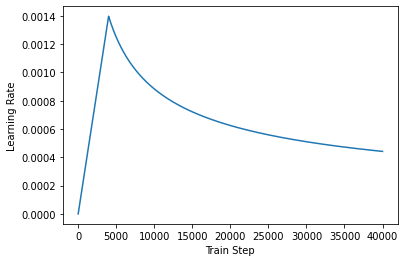

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# Custom Loss and Accuracy

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    #accuracies = tf.cast(accuracies, dtype= tf.float32)

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=ENCODER_VOCAB,
    target_vocab_size=DECODER_VOCAB,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [ ]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
checkpoint_path = "/content/drive/MyDrive/DL Project"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [ ]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [ ]:
# class model_per_epoch(keras.callbacks.Callback):
#     def __init__(self, model,filepath,save_best_only):
#         self.filepath=filepath
#         self.model=model
#         self.save_best_only=save_best_only
#         self.lowest_loss=np.inf
#         self.best_weights=self.model.get_weights()
#     def on_epoch_end(self,epoch, logs=None):
#         v_loss=logs.get('val_loss')
#         if v_loss< self.lowest_loss:
#             self.lowest_loss =v_loss
#             self.best_weights=self.model.get_weights()
#             self.best_epoch=epoch +1
#         if self.save_best_only==False:
#             name= str(epoch) +'-' + str(v_loss)[:str(v_loss).rfind('.')+3] + '.h5'
#             file_id=os.path.join(self.filepath, name)
#             self.model.save(file_id)
#     def on_train_end(self, logs=None):
#         if self.save_best_only == True:
#             self.model.set_weights(self.best_weights)
#             name= str(self.best_epoch) +'-' + str(self.lowest_loss)[:str(self.lowest_loss).rfind('.')+3] + '.h5'
#             file_id=os.path.join(self.filepath, name)
#             self.model.save(file_id)
#             print(' model is returned with best weiights from epoch ', self.best_epoch)
            
# save_dir=r'c:\Temp\models'
# save_best_only= True
# callbacks=[model_per_epoch(model, save_dir, save_best_only)]  

# Training the Model

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
    
        if batch % 100 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
   
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 5.7366 Accuracy 0.2023
Epoch 1 Batch 100 Loss 5.5232 Accuracy 0.2023
Epoch 1 Batch 200 Loss 5.5330 Accuracy 0.2023
Epoch 1 Batch 300 Loss 5.5433 Accuracy 0.2024
Epoch 1 Batch 400 Loss 5.5574 Accuracy 0.2024
Epoch 1 Batch 500 Loss 5.5521 Accuracy 0.2025
Epoch 1 Batch 600 Loss 5.5506 Accuracy 0.2025
Epoch 1 Batch 700 Loss 5.5507 Accuracy 0.2025
Epoch 1 Batch 800 Loss 5.5570 Accuracy 0.2026
Epoch 1 Batch 900 Loss 5.5598 Accuracy 0.2026
Epoch 1 Batch 1000 Loss 5.5655 Accuracy 0.2027
Epoch 1 Batch 1100 Loss 5.5696 Accuracy 0.2027
Epoch 1 Batch 1200 Loss 5.5774 Accuracy 0.2027
Epoch 1 Batch 1300 Loss 5.5800 Accuracy 0.2028
Epoch 1 Batch 1400 Loss 5.5871 Accuracy 0.2028
Epoch 1 Batch 1500 Loss 5.5927 Accuracy 0.2028
Epoch 1 Batch 1600 Loss 5.5972 Accuracy 0.2029
Epoch 1 Batch 1700 Loss 5.6019 Accuracy 0.2029
Epoch 1 Batch 1800 Loss 5.6076 Accuracy 0.2029
Epoch 1 Batch 1900 Loss 5.6108 Accuracy 0.2030
Epoch 1 Batch 2000 Loss 5.6140 Accuracy 0.2030
Epoch 1 Batch 2100 Loss 5

# Evaluation

In [ ]:
def evaluate(input_article):
    input_article = article_tokenizer.texts_to_sequences([input_article])
    input_article = tf.keras.preprocessing.sequence.pad_sequences(input_article, maxlen=ENCODER_LEN, 
                                                                   padding='post', truncating='post')

    encoder_input = tf.expand_dims(input_article[0], 0)

    decoder_input = [summary_tokenizer.word_index['<sos>']]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(DECODER_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == summary_tokenizer.word_index['<eos>']:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights


    

In [ ]:
def summarize(input_article):
    summarized = evaluate(input_article=input_article)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)  
    return summary_tokenizer.sequences_to_texts(summarized)[0]

# Predictions

Below me make predictions on some texts to see how the model is performimg. Since this was a very basic approach the model wont perform that well but it can surely be improved.

In [ ]:
article.iloc[5]

In [ ]:
print("Real Headline : ", summary.iloc[5][5:-5],"\n Predicted Summary : ", summarize(article.iloc[5]))

Real Headline :   The Reverend Pat Storey, 53, is a married mother of two .
She has made history by becoming the Bishop of Meath and Kildare .  
 Predicted Summary :  dr michael clarke is a former church of ireland she has a child with a child with a child and a child she says she is a great thing to do with her father


In [ ]:
article.iloc[16]

"<SOS> By . James Rush . Shocking video footage has emerged of the moment a man was paralysed from the waist down after he was kicked through the top window of a double-decker bus in London. CCTV footage of the incident was captured by a camera on a bus immediately behind the double-decker the man fell from near Finsbury Park, north London. The victim's sister has now said her brother was paralysed following the fall, in which he is understood to have broken his back. SCROLL DOWN FOR VIDEO . This is the shocking moment a man was kicked through the top window of a double-decker bus in London . The 43-year-old victim can be seen falling from the window and landing on the pavement below . The footage, taken on Seven Sisters Road on December 27, 2012, was shown on BBC Two's The Route Masters: Running London's Roads on Sunday. Footage meanwhile taken from inside the bus captured the moment the victim was kicked in the midriff before he fell out of the window. The man's sister, identified as

In [ ]:
print("Real Headline : ", summary.iloc[16][5:-5],"\nPredicted Summary : ", summarize(article.iloc[16]))

Real Headline :   CCTV footage shows moment man fell from top window of London bus .
43-year-old man was kicked in midriff by unknown assailant on top deck .
Force of impact caused window to pop out of frame and man tumbled out .
Victim's sister says he has been  'paralysed' following fall in December 2012 .
Footage emerges during BBC programme about London buses .  
Predicted Summary :  the man was walking into the car in london on saturday he was arrested on suspicion of assault charges he was jailed for two years after he was arrested on suspicion of assault charges


In [ ]:
print("Real Headline : ", summary.iloc[16][5:-5],"\nPredicted Summary : ", summarize(article.iloc[16]))

Real Headline :   CCTV footage shows moment man fell from top window of London bus .
43-year-old man was kicked in midriff by unknown assailant on top deck .
Force of impact caused window to pop out of frame and man tumbled out .
Victim's sister says he has been  'paralysed' following fall in December 2012 .
Footage emerges during BBC programme about London buses .  
Predicted Summary :  man was caught on camera in london when he was hit by a train driver was caught on camera in london police were called to the scene and he was taken to hospital where he was taken to hospital


In [ ]:
print("Real Headline : ", summary.iloc[16][5:-5],"\nPredicted Summary : ", summarize(article.iloc[16]))

Real Headline :   CCTV footage shows moment man fell from top window of London bus .
43-year-old man was kicked in midriff by unknown assailant on top deck .
Force of impact caused window to pop out of frame and man tumbled out .
Victim's sister says he has been  'paralysed' following fall in December 2012 .
Footage emerges during BBC programme about London buses .  
Predicted Summary :  bus driver was attacked by a bus driver in london on saturday driver was attacked by a driver and his family were on the bus driver was on the road in london after he was attacked by a bus driver david taylor who was driving back to london


In [ ]:
article.iloc[23]

In [ ]:
print("Real Headline : ", summary.iloc[23][5:-5],"\nPredicted Summary : ", summarize(article.iloc[23]))

Real Headline :   Stephen Fidler, 41, was at beach with family in Qatar, Middle East .
Inquest heard he decided to go for a dive after playing in the sea with sons .
Climbed onto landing board platform before plunging head first into water .
But water was shallower than he'd thought and he struck head on sea bed .  
Predicted Summary :  david williams 24 died after being hit by water on the coast of the sea he had been on the coast of the sea with his wife and husband david williams mr williams died after being hit by a water and fell from the water
